# GID-Tomography 

In [2]:
import os, glob, time, sys, tomopy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from joblib import Parallel, delayed
from scipy import signal

HOME_PATH = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/ETsai/waxs/'
GI_TOMO_PATH = HOME_PATH+'GI_tomo/'
GI_TOMO_PATH in sys.path or sys.path.append(GI_TOMO_PATH)

import analysis.peaks as peaks
import analysis.tomo as tomo
import analysis.seg as seg
import analysis.util as util
import analysis.io as io


util.print_time()

%pwd

2023/07/06 15:06:45



'/nsls2/data/cms/legacy/xf11bm/data/2022_3/ETsai/waxs/analysis/GI_tomo'

## (0) Specify param

In [3]:
# =============================================================================
# Specify input
# =============================================================================
os.chdir(HOME_PATH)
#source_dir = './stitched/'
source_dir = './raw/'
out_dir = './analysis/results_tomo/'
infiles = glob.glob(os.path.join(source_dir, '*WAXSpos1*_pos1*.tiff')) #TIFF or NPZ
print(infiles[0])
N_files = len(infiles); print('N_files = {}'.format(N_files))

filename = 'sam3'; print(filename)
if os.path.exists(out_dir) is False: os.mkdir(out_dir)
if 'npz' in infiles[0]:
    infile_type = 'npz'
else:
    infile_type =  'tiff'          

    
#### Steps (**only for the first time)
# 1) **Load some 2D data to see peak locations
# 2) **Select/Load roi for peaks 
# 3) **Get peaks from each 2D data. NOTE: slow due to many files
# 4) Generate sinogram for each domain 
# 5) Label peak positons (in deg) for sinos. Use the largest domain (high-intensity peak) to define the set of angles corresponding to one domain.
# 6) Refer to previous step, select domains
# 7) For each domain, generate sinogram and recon
# 8-10) Post-processing/Visualization

run_steps = [1] 
flag_LinearSubBKG = 0
flag_load_peaks = 1 
flag_save_png = 0
flag_save_npy = 0
extra='_more'
verbose = 0



./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_13_x0.000_th0.120_1.00s_790275_000186_waxs.tiff
N_files = 7560
sam3


In [3]:
7560/360

21.0

## (1) Load input files

Load and save 2D data and metadata (x, phi)

In [4]:
# =============================================================================
# Load all/some data and plot sum
# =============================================================================
data_all = []
phi_max = 179.5

if 1 in run_steps:
    t0 = time.time()   
    
    fraction = 1  # Quick checck peak positions
    df_list = []
    for ii, infile in enumerate(infiles):
        if ii%1000==0: 
            print("{}/{}, {}".format(ii, N_files, infile)) 
            
        if ii%fraction==0: 
            if infile_type == 'npz':
                temp = np.load(infile)
                data = temp['image']
                x_axis = temp['x_axis']
                y_axis = temp['y_axis']
            else:
                temp = Image.open(infile).convert('I')
                data = np.copy(np.asarray(temp))
            
            ### Save all data
            data_all.append(data)
            
            ### Get the summed data
            if ii==0:
                data_sum = data
            else:
                data_sum = data_sum+data
                
                
            ### Extract metadata: x, phi
            idx = infile.find('x')
            infile_short = infile[idx-2:]
            temp = infile_short.split('_')
            a = -3
            zigzag_n = int(temp[3+a])
            pos_x = float(temp[4+a][1:])
            scan_n = int(temp[7+a])
            if zigzag_n%2==0:
                pos_phi = phi_max-float(temp[8+a])/2.0
            else:
                pos_phi = float(temp[8+a])/2.0

            df = pd.DataFrame({'pos_phi':pos_phi,
                               'pos_x':pos_x,
                               'zigzag_n':zigzag_n,
                               'scan_n': scan_n,
                              }, index = [pos_phi]
                            )
            df_list.append(df)
    
    # Pass the list of dfs to a big df
    df_peaks = pd.concat(df_list)
    print(df_peaks)    

                
    data_avg = data_sum/np.size(infiles)*fraction    
    print("Loading data took {:.0f} s".format(time.time()-t0))
        

0/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_13_x0.000_th0.120_1.00s_790275_000186_waxs.tiff
1000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_23_x2.000_th0.120_1.00s_790285_000340_waxs.tiff
2000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_3_x-2.000_th0.120_1.00s_790265_000300_waxs.tiff
3000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_8_x-1.000_th0.120_1.00s_790270_000166_waxs.tiff
4000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_18_x1.000_th0.120_1.00s_790280_000129_waxs.tiff
5000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_21_x1.600_th0.120_1.00s_790283_000312_waxs.tiff
6000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_11_x-0.400_th0.120_1.00s_790273_000152_waxs.tiff
7000/7560, ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_19_x1.200_th0.120_1.00s_790281_000040_waxs.tiff
       pos_phi  pos_x  zigzag_n  scan_n
93.0      93.0    0.0         3  790275
0.0        0.0    0.0         3  790275
137.0    137.0    2.0         3  790285
104.0    104.0    1.4         0  7

__Save 2D data stack (takes GB)__

756 of 1043*981 was 3GB

In [6]:
print(len(data_all))
print(data_all[0].shape)

7560
(1043, 981)


In [22]:
if 1: 
    filename_saved = filename + '_data_all_WAXS1'
    fn_out = out_dir+filename_saved
    fn_out = util.check_file_exist(fn_out, ext='.npy')
    np.save(fn_out, data_all)

Saving to ./analysis/results_tomo/sam3_data_all_WAXS1_1.npy


In [8]:
if 1: 
    filename_saved = filename + '_df_all_WAXS1'
    fn_out = out_dir+filename_saved
    fn_out = util.check_file_exist(fn_out, ext='.pkl')
    df_peaks.to_pickle(fn_out)

Saving to ./analysis/results_tomo/sam3_df_all_WAXS1.pkl


__Plot 2D__

Text(0.5, 1.0, 'Average over 7560 data (fraction=1/100) \n ./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_13_x0.000_th0.120_1.00s_790275_000186_waxs.tiff')

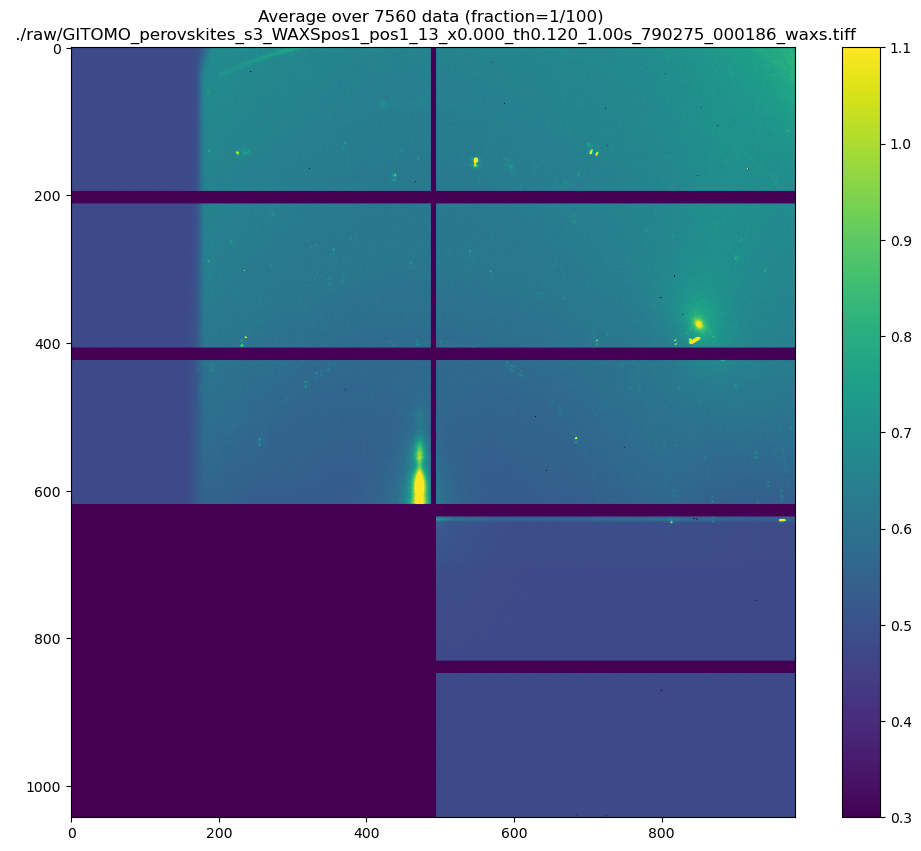

In [99]:
data_avg = np.nan_to_num(data_avg)

# Plot    
plt.figure(1, figsize=(12,10)); plt.clf()
if infile_type == 'npz':
    extent = (np.nanmin(x_axis), np.nanmax(x_axis), np.nanmin(y_axis), np.nanmax(y_axis))
    plt.imshow((data_avg+3), origin='bottom', extent=extent) #, vmin=0.5, vmax=1.8) 
    plt.ylim(0, np.nanmax(y_axis))
    #plt.grid(axis='x'); plt.colorbar()
else:
    plt.imshow(np.log10(data_avg+3), vmin=0.3, vmax=1.1)
plt.colorbar()
plt.title('Average over {} data (fraction=1/{}) \n {}'.format(N_files,fraction,infiles[0]))



__Save summed 2D data__

In [4]:
# Save png
flag_save_png = 1
flag_save_npy = 1
flag_save_tiff = 1
filename_saved = filename+'_data_avg_WAXS1'

if flag_save_png:
    fn_out = out_dir+'fig1_'+filename_saved
    fn_out = util.check_file_exist(fn_out, ext='.png')
    plt.savefig(fn_out, format='png')

# Save as npy
if flag_save_npy:
    fn_out = out_dir+filename_saved
    fn_out = util.check_file_exist(fn_out, ext='.npy')
    np.save(fn_out, data_avg)
        
    if False:
        fn_out = out_dir+filename_saved
        data_avg = np.load(fn_out+'.npy')
        

# Save as tiff
if flag_save_tiff:
    data_avg = np.nan_to_num(data_avg)
    final_img = Image.fromarray(data_avg.astype(np.uint32))
    infile_done = out_dir+filename_saved
    infile_done = util.check_file_exist(infile_done, ext='.tiff')
    final_img.save(infile_done)     

    # Plot qr (after use SciAnalysis on the tiff file)
    if 0:
        fn = './waxs/analysis/qr_image/TOMO_T1_real_data_avg.npz'
        qinfo = np.load(fn)
        qr_image = qinfo['image']
        x_axis = qinfo['x_axis']
        y_axis = qinfo['y_axis']
        extent = (np.nanmin(x_axis), np.nanmax(x_axis), np.nanmin(y_axis), np.nanmax(y_axis))
        plt.figure(11, figsize=[12,8]); plt.clf()
        plt.imshow(np.log10(qr_image), origin='bottom', extent=extent, vmin=1.1, vmax=1.8) 
        plt.ylim(0, np.nanmax(y_axis))
        plt.grid(axis='x'); plt.colorbar()
        plt.title(fn)

        fn_out = out_dir+filename+'_qr.png'
        plt.savefig(fn_out, format='png')

    # Load and plot
    if False:
        temp = Image.open(infile_done).convert('I') # 'I' : 32-bit integer pixels
        data_avg_infile = np.copy( np.asarray(temp) )
        plt.figure(2); plt.clf()
        plt.imshow(data_avg_infile)
        plt.clim(0, 20)
        plt.colorbar()
        plt.show()


Saving to ./analysis/results_tomo/fig1_sam3_data_avg_WAXS2_1.png
Saving to ./analysis/results_tomo/sam3data_avg_WAXS2_1.npy
Saving to ./analysis/results_tomo/sam3_data_avg_WAXS2_1.tiff


<Figure size 640x480 with 0 Axes>

In [27]:
%pwd

'/nsls2/data/cms/legacy/xf11bm/data/2022_3/ETsai/waxs'

## (2) Pick peak ROI 

Specify in TXT the center, size, peak:

[[575, 252], [60, 10], 'sum002'],


In [97]:
%matplotlib ipympl
#%matplotlib inline

./raw/GITOMO_perovskites_s3_WAXSpos1_pos1_13_x0.000_th0.120_1.00s_790275_000186_waxs.tiff
Parse param manually for now..



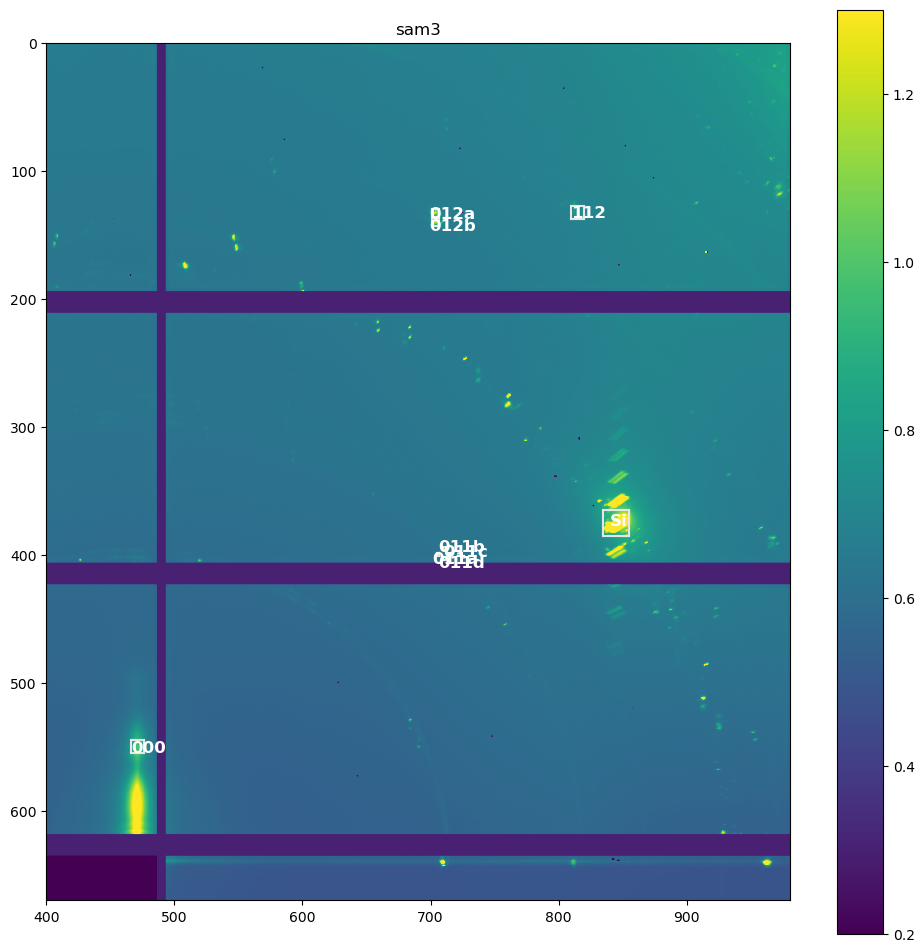

In [112]:
## Get ROI for each peak from 2D data (step 2)
filename_peak = '/nsls2/data/cms/legacy/xf11bm/data/2022_3/ETsai/waxs/analysis/GI_tomo/param/C8BTBT_peaks.txt'
filename_df_peaks = 'df_peaks_all_subbg{}{}'.format(flag_LinearSubBKG, extra)

flag_save_png = 0
flag_save_npy = 0


####### Get peak roi from scattering pattern
if 0:
    peak_list = io.read_peak_list(filename_peak)
else:
    peak_list = [
         [[550, 471], [10, 10], 'sum000'],
         [[400, 706], [3, 3], 'sum011a'],
         [[395, 711], [3, 3], 'sum011b'],
         [[400, 715], [3, 3], 'sum011c'],
         [[403, 711], [3, 3], 'sum011d'],
        
         [[133, 704], [6, 6], 'sum012a'],
         [[140, 704], [6, 6], 'sum012b'],
        
         [[133, 815], [10, 10], 'sum112'],
        
         [[375, 845], [20, 20], 'sumSi'],
         #[[400, 700], [50, 50], 'sum011'],
    ]    

if 0:
    q_file = HOME_PATH+'analysis/q_image/TOMO_S4_sam3_R_10_x-3.400_th0.110_1.00s_42366_000000_waxs.npz'
    temp = np.load(q_file)
    q_image = temp['image']
    x_axis = temp['x_axis'] 
    y_axis = temp['y_axis'] 
    x_scale = temp['x_scale'] 
    y_scale = temp['y_scale'] 
    #fig = plt.figure(4, figsize=[8,8]); plt.clf(); 
    #X, Y = np.meshgrid(x_axis, y_axis)
    #plt.pcolormesh(X, Y, np.log10(q_image))
#    calibration.set_beam_position(462, 1043-398)

if 1:  #2 in run_steps:     
    
    %matplotlib inline
    #### Plot to define roi
    fig = plt.figure(3, figsize=[12,12]); plt.clf(); 
    ax = fig.add_subplot(111)
    aa = ax.imshow(np.log10(data_avg+3), vmin=0.2, vmax=1.3)
    plt.title(filename)
    plt.colorbar(aa)
    peaks.get_peaks(infiles[0], peak_list, phi_max=360, verbose=2)
    ax.set_xlim(145,981)
    ax.set_ylim(670,0)

    if 0:
        xticks = np.asarray([471+ii*109.6 for ii in np.arange(-3, 4.1, 1)])
        xticklabels = ["{:5.1f}".format(i) for i in ((xticks-471)*x_scale)];
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        yticks = xticks = np.asarray([651+ii*109.6 for ii in np.arange(0, -6, -1)])
        yticklabels = ["{:5.1f}".format(i) for i in ((651-yticks)*y_scale)];
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
    
    ## Save png
    if flag_save_png:
        fn_out = out_dir+'fig5_'+filename+'_peak_roi.png'
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')
    
    ## Save peak_list in npy
    if flag_save_npy:
        fn_out = out_dir+'peak_list'
        fn_out = util.check_file_exist(fn_out)
        np.save(fn_out, peak_list)


## (3) Get peaks 

### Option 1. Get peaks from TIFF

In [86]:
# =============================================================================
# Get peaks from raw tiff files
# =============================================================================
if 3 in run_steps:     
    t0 = time.time()
    flag_load_parellel = 0  # Sometimes parallel doesn't work..
    if flag_load_parellel:
        with Parallel(n_jobs=3) as parallel:
            results = parallel( delayed(peaks.get_peaks)(infile, peak_list, phi_max=360, verbose=1, flag_LinearSubBKG=flag_LinearSubBKG) for infile in infiles )
    else:
        results = []
        for ii, infile in enumerate(infiles):
            #if ii%10==0:
            temp = peaks.get_peaks(infile, peak_list, phi_max=360, verbose=1, flag_LinearSubBKG=flag_LinearSubBKG)
            results.append(temp)
    print("\nLoad data and define peak roi: {:.0f} s".format(time.time()-t0))
    
    
    # Pass to pd
    df_peaks = pd.DataFrame()
    for ii, df in enumerate(results):
        df_peaks = df_peaks.append(df, ignore_index=True)
    print(df_peaks)
    print(df_peaks.columns)
    
    # Save 
    fn_out = out_dir+'df_peaks_all_subbg{}{}'.format(flag_LinearSubBKG, extra)
    fn_out = util.check_file_exist(fn_out)
    df_peaks.to_csv(fn_out)
 
    # Calculate area
    areas = peaks.calc_area_peakROI(peak_list)

### Option 2. Get peaks from stack & df

In [113]:
for peak in peak_list:
    print(peak)

[[550, 471], [10, 10], 'sum000']
[[400, 706], [3, 3], 'sum011a']
[[395, 711], [3, 3], 'sum011b']
[[400, 715], [3, 3], 'sum011c']
[[403, 711], [3, 3], 'sum011d']
[[133, 704], [6, 6], 'sum012a']
[[140, 704], [6, 6], 'sum012b']
[[133, 815], [10, 10], 'sum112']
[[375, 845], [20, 20], 'sumSi']


In [114]:
# =============================================================================
# Get peaks from df
# =============================================================================
if 1:     
    for peak in peak_list:
        area_sum = []
        for data in data_all:
            area = peaks.ArrayCrop(data=data, center=peak[0], size=peak[1])  
            area_sum.append(np.sum(area))
        df_peaks[str(peak[2])] = area_sum
    
    # Save 
    if 0:
        fn_out = out_dir+'df_peaks_all_subbg{}{}'.format(flag_LinearSubBKG, extra)
        fn_out = util.check_file_exist(fn_out)
        df_peaks.to_csv(fn_out)


In [115]:
df_peaks

,pos_phi,pos_x,zigzag_n,scan_n,sum000,sum011a,sum012a,sum012b,sum011b,sum011c,sum011d,sumSi,sum0112a,sum112
93.0,93.0,0.0,3,790275,317,6,47,36,3,0,3,1342,167,167
0.0,0.0,0.0,3,790275,510,7,84,79,5,6,3,1390,309,309
137.0,137.0,2.0,3,790285,377,0,46,38,6,3,6,386,156,156
104.0,104.0,1.4,0,790282,984,2,46,41,3,4,4,7332,143,143
19.0,19.0,-0.8,9,790271,636,3,83,64,9,3,4,2604,202,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23.0,23.0,-0.2,2,790274,627,8,58,71,5,4,5,1250,204,204
13.5,13.5,1.6,1,790283,529,9,64,59,11,5,4,23273,197,197
105.0,105.0,-0.4,1,790273,353,6,41,50,11,4,3,6399,184,184
36.0,36.0,-2.0,3,790265,304,6,46,47,6,3,3,576,219,219


## (4) Get Sinogram

Need to load the entire dataset (cannot do e.g. 10%), go to Step (1) and load the data

# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
# Checking sino & Fill empty data frame
NOTE: proj[proj<np.median(proj)*thr] = 1
['sum000', 'sum011a', 'sum012a', 'sum012b', 'sum011b', 'sum011c', 'sum011d', 'sumSi', 'sum0112a', 'sum112']


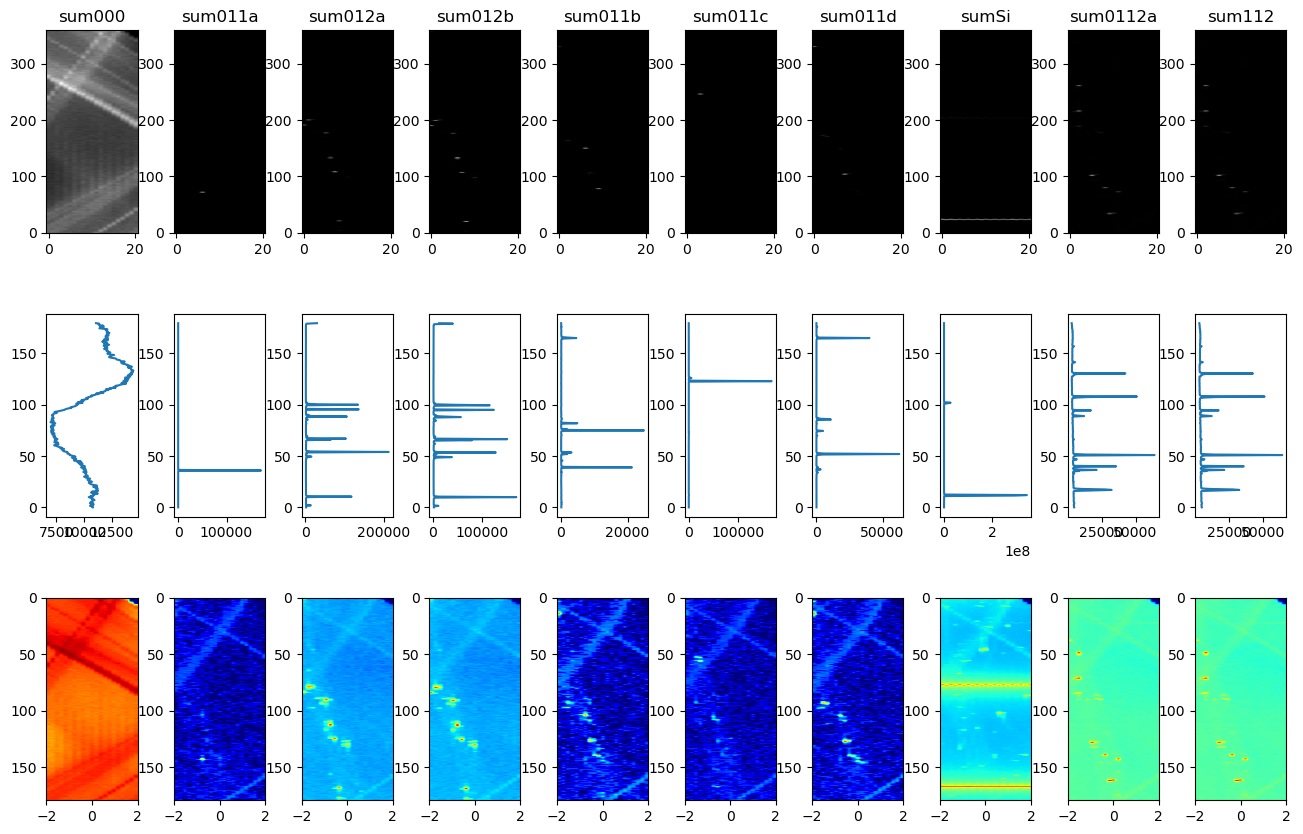

In [116]:
# =============================================================================
# Get sino for each peak
#
# Adjust parameters to make sure sinograms look good 
#   1) Check if background/artefacts are more or less removed 
#   2) Check if main features are still there after correction, eg Si has 4 lines
# Adjust parameters to make sure reconstruction looks good
#   1) 00L recon should roughly cover the sample shape
#   2) Choose algo and rotational center
# =============================================================================

flag_load_peaks = 0 
if flag_load_peaks:
    print('Loading {}'.format(out_dir+filename_df_peaks))
    df_peaks = pd.read_csv(out_dir+filename_df_peaks)

### Create sino from pd data    
list_peaks = []      # Empty if getting all peaks from df_peaks, else specify eg 'sum11L'
data_sort, sino_dict = tomo.get_sino_from_data(df_peaks, list_peaks=list_peaks, flag_rm_expbg=0, thr=0.1, binary=None) 
print(sino_dict['list_peaks'])

sino_sum = tomo.get_sino_sum(sino_dict)
sino_dict['areas'] = peaks.calc_area_peakROI(peak_list)   # Assuming list_peaks are the same as peak_list


### Plot all peak-sino        
#tomo.plot_sino(sino_dict, fignum=14, title_st=filename, vlog10=[0, 5.5])

sino_allpeaks = sino_dict['sino_allpeaks']
theta = sino_dict['theta']
axis_x = sino_dict['axis_x']
list_peaks = sino_dict['list_peaks']

fignum = 15
fig = plt.figure(fignum, figsize=(16,10)); #plt.clf() 
fig.subplots_adjust(hspace=0.4, wspace=0.4)
Npeaks =  sino_allpeaks.shape[2]

for ii in np.arange(0, sino_allpeaks.shape[2]):
    sino = sino_allpeaks[:,:,ii]
    sum_sino = np.sum(sino, 1)   
    peak = list_peaks[ii] if list_peaks!=[] else ''

    #plt.subplot(3,Npeaks,ii+1)
    ax = fig.add_subplot(3,Npeaks,ii+1)
    ax.imshow(sino, origin= 'lower', cmap='gray', aspect='auto') #, vmin=0, vmax=1) #, extent = [axis_x[0], axis_x[-1], theta[-1], theta[0]])
    #ax.axis('off')
    plt.title(sino_dict['list_peaks'][ii])

    ax = fig.add_subplot(3,Npeaks,ii+1+Npeaks)
    ax.plot(sum_sino, theta)
    #ax.axis('off')
    #peaks_idx = tomo.label_peaks(theta, sum_sino, onedomain=1, axis_flip=1)
    ### Overlay with log10 
    #ax2 =ax1.twiny()
    #ax2.plot(np.log10(sum_sino), theta, 'r', alpha=0.3);
    #x2.axis('off'); ax1.axis('off')

    ax = fig.add_subplot(3,Npeaks,ii+1+Npeaks*2)            
    ax.imshow(np.log10(sino+1), origin= 'lower', cmap='jet', aspect='auto', extent = [axis_x[0], axis_x[-1], theta[-1], theta[0]]) #, vmin=0, vmax=2)
    #ax.axis('off')

    #if ii==sino_allpeaks.shape[2]-1:
    #    plt.colorbar(orientation='horizontal', pad=0.01)    
                


if flag_save_png:
    fn_out = out_dir+'fig14_'+filename+'peaks_sino' 
    fn_out = util.check_file_exist(fn_out)
    plt.savefig(fn_out, format='png')

## (5) **Provide relative rotational angle between peaks

In [ ]:
# =============================================================================
# Label peak positons (in deg) for sinos
#
# Shows the 1D plot (integreated intensity versus degree)
# =============================================================================
flag_load_list_peaks = 1 
if 5 in run_steps:     
    if flag_load_list_peaks==0:
        list_peaks = sino_dict['list_peaks']
        flag_log10 = 0 # Use 1 only for plotting
        
        x = {}; jj=0
        N = len(list_peaks[0:-1])
        plt.figure(20, figsize=[15, 8]); plt.clf()
        for ii, peak in enumerate(list_peaks[0:-1]):
        #peak =  'sum20L'
        #if 1:
            sino, sum_sino, theta = tomo.get_sino_from_a_peak(sino_dict, peak) # which peak roi
            if flag_log10: 
                sum_sino = np.log10(sum_sino)    
            plt.subplot(N,1,ii+1)
            plt.plot(theta, sum_sino, color='k');  
            plt.axis('off')     
            if 'b' in peak: color = [0, 0.5, 0] 
            else: color = 'b'
            plt.text(-23, np.max(sum_sino)*0.7, peak, fontsize=8, color=color)
            if ii==0: plt.title(HOME_PATH+', '+filename)
            
            peaks_idx = tomo.label_peaks(theta, sum_sino, onedomain=1)
            
            ## Store peaks and corresponding angles to a df for reconstructing ONE domain
            ''' Example
            x = {}; jj=0
            #sum20L
            x[jj] = pd.DataFrame([[28.5, 'sum20L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[209, 'sum20L']], columns=['angle','peak']); jj = jj+1
            #sum21L
            x[jj] = pd.DataFrame([[51, 'sum21L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[190, 'sum21L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[231, 'sum21L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[10, 'sum21L']], columns=['angle','peak']); jj = jj+1
            '''
            '''
            for angle in theta[peaks_idx]:
                if 1: #angle<181: #why
                    x[jj] = pd.DataFrame([[angle, peak]], columns=['angle','peak'])
                    jj = jj+1
                    plt.plot([angle, angle], [0, np.max(sum_sino)*1.1], 'r', linewidth=5, alpha=0.3)
            '''
            jj=0
            x[jj] = pd.DataFrame([[-53.87, 'sum11L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[-53.87+107.75, 'sum11L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[-53.87-12.8, 'sum11Lb']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[-53.87-12.8+107.75, 'sum11Lb']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[0, 'sum02L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[-53.87+19.5, 'sum12L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[-53.87+19.5+68.8, 'sum12L']], columns=['angle','peak']); jj = jj+1
            x[jj] = pd.DataFrame([[-53.87-29, 'sum20L']], columns=['angle','peak']); jj = jj+1
            
        #--- Save to npy
        if flag_save_npy:
            fn_out = out_dir+'angles_onedomain'
            fn_out = util.check_file_exist(fn_out)
            np.save(fn_out, x)
            
        #--- Save to png
        if flag_save_png:
            fn_out = out_dir+'fig20_peak_deg' #+peak
            fn_out = util.check_file_exist(fn_out)
            plt.savefig(fn_out, format='png')

        temp_list = pd.concat(x)
        print(temp_list) #print(list_peaks_angles_orig.sort_values('angle'))
    
        #--- Remove peaks not needed for sino
        list_peaks_angles_orig = temp_list[temp_list.peak !='sumSi']
    else:
        temp = np.load(HOME_PATH+'/GI_tomo/list_peaks_angles_orig_S2.npy', allow_pickle=True)
        list_peaks_angles_orig = pd.DataFrame(temp,columns=['angle','peak'])
        list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sumSi']
        list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sumSib']
        
    #print('## Compare the list with the figure and drop unwanted peaks.')
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum118']
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum117b']
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum118b']
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum2012']    
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum2013']  
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum206b']  
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum2012b']  
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum2013b'] 
    list_peaks_angles_orig = list_peaks_angles_orig[list_peaks_angles_orig.peak !='sum2014b']
    #rm = []
    #for tt, temp in enumerate(list_peaks_angles_orig.peak):
    #    if 'b' in temp: rm.append(tt)
    #list_peaks_angles_orig = list_peaks_angles_orig.drop(rm)

    print(list_peaks_angles_orig)
    if verbose>1:
        #tomo.plot_angles(list_peaks_angles_orig['angle']+90, labels=list_peaks_angles_orig['peak'], color='b', FS=9, fignum=21)    
        tomo.plot_angles(list_peaks_angles_orig['angle']+90, labels=[], color='b', FS=9, fignum=21)  
        
    if flag_save_png:
        fn_out = out_dir+'fig21_angles' #+peak
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')
    


## (6) Major domains to recontruct

In [ ]:
# =============================================================================
# Different domains
# 
# Pick out all (major) domains: 
# Each domain should have eg 11L showing up at certain rotational angles. Assuming the angular sampling is sufficient and that scattering at 11L has sufficient scatering SNR, all domains are captured in the 11L sinogram.
# =============================================================================      
if 6 in run_steps: 
    peak_strong = 'sum02L'
    sino, sum_sino, theta = tomo.get_sino_from_a_peak(sino_dict, peak_strong) #choose
    
    if verbose>-1:
        plt.figure(25, figsize=[20, 8]); plt.clf()
        plt.subplot(1,2,1)
        plt.imshow(sino, extent=[1, 50, 360, 0], cmap='gray_r'); plt.axis('auto'); #plt.ylabel('rotation')
        #plt.imshow(sino); plt.axis('auto'); plt.ylabel('rotation')
        plt.subplot(1,2,2)
        plt.plot(theta, sum_sino, alpha=0.8);  
        plt.title('sum_sino for {}'.format(peak_strong)); #plt.grid()
        #peaks_idx = tomo.label_peaks(theta, sum_sino, onedomain=0, fontsize=8)
        #print(*theta[peaks_idx], sep=', ')       

    ####### Specify domains
    print('## Select the main peaks for reconstruction of different domains. See above for recommendations.')
    #domain_angle_offset = np.arange(15, 41, 1)
    #domain_angle_offset= np.append(domain_angle_offset, np.arange(68, 118, 1))
    #domain_angle_offset= np.append(domain_angle_offset, np.arange(125, 132, 1))  
    #domain_angle_offset= np.append(domain_angle_offset, np.arange(152, 167, 1)) 
    #domain_angle_offset= np.append(domain_angle_offset, np.arange(174, 181, 1))     
    #domain_angle_offset= np.append(domain_angle_offset, [0, 1])    
    
    domain_angle_offset = theta[sum_sino>3000]
    domain_angle_offset = domain_angle_offset[domain_angle_offset<=180]
    
    domain_angle_offset = np.sort(domain_angle_offset)
    print('Nangle={}, domain_angle_offset = {}'.format(len(domain_angle_offset), domain_angle_offset))
    
    if verbose>-1:
        plt.figure(25); plt.subplot(1,2,2)
        plt.bar(domain_angle_offset, np.ones(domain_angle_offset.size)*np.max(sum_sino)*1.02, alpha=0.2, color='r', width=0.5);  
         
        if flag_save_png:
            fn_out = out_dir+'fig25_sum_sino' #+peak
            fn_out = util.check_file_exist(fn_out)
            plt.savefig(fn_out, format='png')
            

## (7) Domain Reconstruction

In [ ]:
# =============================================================================
# Do recon for each domain
# =============================================================================
flag_adp_thr = 0

if 7 in run_steps: 
    t0 = time.time()
    recon_all_list = []; sino_all_list = []
    list_peaks_angles = list_peaks_angles_orig.copy()
    
    flag_normal = 2 # 1(normalize max to 1), 2(divided by the ROI area), 3 (binary)
    width = 2
    algo = 'gridrec' #'fbp'
    flag_fill = 1   
    rot_offset = int(rot_center - sino.shape[1]/2)
    
    if verbose>1: plt.figure(30, figsize=[20, 10]); plt.clf()
    for ii, offset in enumerate(domain_angle_offset):  
        print('offset = {}'.format(offset))
        angles_old = list_peaks_angles_orig['angle'] -112
        angles_new = angles_old + offset
        list_peaks_angles['angle'] = angles_new
    
        ## Get sino
        sino_dm = tomo.get_combined_sino(sino_dict, list_peaks_angles.sort_values('angle'), phi_max=360, width=width, flag_normal=flag_normal, verbose=0)

        if flag_fill:
            sino_dm = np.roll(sino_dm, -rot_offset, axis=1)
            sino_dm = tomo.fill_sino(sino_dm, thr=1)
        
        ## Plot sino
        if verbose>1: 
            if ii==0:
                title_st = '{}\nflag_normal={}'.format(filename,flag_normal) 
            else:
                title_st = ''
            plt.subplot(2,len(domain_angle_offset),ii+1)
            tomo.plot_sino((sino_dm), theta = sino_dict['theta'], axis_x = sino_dict['axis_x'], title_st=title_st, fignum=-1)
        #plot_angles(list_peaks_angles['angle'], fignum=51)    
        
        ## Tomo recon
            plt.subplot(2,len(domain_angle_offset),len(domain_angle_offset)+ii+1)
            title_st = '[{}] ori={}$^\circ$'.format(ii,offset)
        else: 
            title_st = ''

        if flag_adp_thr:
            temp_recon, temp_sino = seg.do_seg_sino(sino_dm, thetas = sino_dict['theta'], thr_range=[0.3, 0.8, 0.05], use_err=-1, rot_center=rot_center-rot_offset, algo='fbp')  
            recon_all_list.append(temp_recon)
        else:
            temp = tomo.get_plot_recon(sino_dm, theta = sino_dict['theta'], rot_center=rot_center-rot_offset, algorithms = [algo], title_st=title_st, fignum=None, colorbar=True)
            recon_all_list.append(np.squeeze(temp['_{}'.format(algo)]))
        
        sino_all_list.append(sino_dm)
        
    if verbose>1 and flag_save_png:     
        fn_out = out_dir+'fig30_recon'
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')

    print("Time = {:.1f} min.\n".format((time.time()-t0)/60))   

## (8) Plot a domain

__Mask__

In [ ]:
# =============================================================================
# Load mask & Define thr
# =============================================================================
if 1:
    x = np.asarray(Image.open("./mask_T1.png").convert("L").rotate(0).resize((50,50)))
    #x = np.pad(x, [(0, 2), (0, 2)], mode='constant', constant_values=0)
    #x = np.roll(x, 3, axis=0)
    #x = np.roll(x, 0, axis=1)
    # plt.imshow(x, alpha = 1, cmap='binary')
    x = x.astype('float')
    x[x<3] = 0
    x[x>0] = 1.0
    mask = x.copy()
    x[x==0] = np.nan
else:
    x = 1

try:
    Ndomain = len(domain_angle_offset)    
    thr = np.zeros([Ndomain])
    for ii, recon in enumerate(recon_all_list):
        if flag_adp_thr==0:
            thr[ii] = np.nanmax(recon)*0
        else:
            thr[ii] = 0.0
except:
    print('')


__Plot__

In [ ]:
# =============================================================================
# Plot a domain
# =============================================================================          
if 8 in run_steps:
    domain_plot = 177 #34 #177.5 # 136 ## in deg
    idx = np.argmin(np.abs(domain_angle_offset - domain_plot))
    list_peaks_angles = list_peaks_angles_orig.copy()
    flag_fill = 1
    rot_offset = int(rot_center - sino.shape[1]/2)
    
    if 1:   ## Tune recon param
        flag_normal = 1 # 1(normalize max to 1), 2(divided by ROI area), 3 (binary)
        width = 0
        algo = 'gridrec' ##'gridrec' #'fbp'

        offset = domain_angle_offset[idx]
        print('offset = {}'.format(offset))
        angles_old = list_peaks_angles_orig['angle'] - 112
        angles_new = angles_old + offset
        list_peaks_angles['angle'] = angles_new
        
        sino_dm = tomo.get_combined_sino(sino_dict, list_peaks_angles.sort_values('angle'), width=width, flag_normal=flag_normal, verbose=0)
        if flag_fill:
            sino_dm = np.roll(sino_dm, -rot_offset, axis=1)
            sino_dm = tomo.fill_sino(sino_dm, thr=1)
        
        #---- Recon
        temp = tomo.get_plot_recon(sino_dm, theta = sino_dict['theta'], rot_center=rot_center-rot_offset, algorithms = [algo], title_st='', fignum=None, colorbar=True)        
        recon = np.squeeze(temp['_{}'.format(algo)])

        #---- Recon with thr
        recon_thr, sino_thr = seg.do_seg_sino(sino_dm, thetas = sino_dict['theta'], thr_range=[0, 0.9, 0.05], use_err=-1, rot_center=25, algo=algo)  

    else:   
        recon = recon_all_list[idx]
        sino_dm = sino_all_list[idx]
       
    plt.figure(37, figsize=[4,8]); plt.clf() 
    plt.subplot(2,4,1)     
    plt.imshow(sino_dm, cmap='YlGnBu'); plt.axis('auto')
    plt.xticks([])
    plt.title('{:.1f}$^\circ$'.format(domain_angle_offset[idx]))
    cbar = plt.colorbar(fraction=0.05, pad=0.0, aspect=30, ticks=[0,1]) 

    plt.subplot(2,4,2)     
    plt.imshow(sino_thr, cmap='YlGnBu'); plt.axis('auto')
    
    plt.subplot(2,4,3)
    #plt.figure(38, figsize=[7,7]); plt.clf()
    plt.imshow(x, alpha = 1, cmap='binary')
    plt.imshow(recon*x, cmap='PuBu'); plt.axis('off')
    cbar = plt.colorbar(fraction=0.04, pad=0.0, aspect=16) 
    plt.title('{:.1f}$^\circ$'.format(domain_angle_offset[idx]))
    
    plt.subplot(2,4,4)
    #plt.figure(39, figsize=[7,7]); plt.clf()
    plt.imshow(x, alpha = 1, cmap='binary')
    plt.imshow(recon_thr*x, cmap='PuBu'); plt.axis('off')
    cbar = plt.colorbar(fraction=0.04, pad=0.0, aspect=16) 
    plt.title('recon_thr, {:.1f}$^\circ$'.format(domain_angle_offset[idx]))  
    
    ### FFT
    sino_fft_abs = util.get_fft_abs(sino_dm)
    plt.subplot(2,4,5)     
    plt.imshow(sino_fft_abs, aspect='auto')

    sino_fft_abs = util.get_fft_abs(sino_thr)
    plt.subplot(2,4,6)     
    plt.imshow(sino_fft_abs, aspect='auto')

    
    ##------ Save PNG
    if flag_save_png:     
        fn_out = out_dir+'fig35_recon'
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')


## (9) Plot recon after thr

In [ ]:
# =============================================================================
# Plot some recons after threshold
# =============================================================================    
if 9 in run_steps:
    ##------ Sort domains by the largest recon val       
    idx_large = np.argsort(thr)

    ##------ Plot the domains with large recon val
    plt.figure(40, figsize=[20,10]); plt.clf()   
    for ii in np.arange(1,31):
        idx = idx_large[-ii]
        recon = recon_all_list[idx]
        recon[recon<thr[ii]] = 0 #np.nan   
        
        plt.subplot(5,6,ii)  
        plt.imshow(x, alpha = 1, cmap='binary')
        plt.imshow(recon*x); plt.axis('off')
        #plt.colorbar()
        plt.title('{:.1f}$^\circ$'.format(domain_angle_offset[idx]))
    
    ##------ Save PNG
    if flag_save_png:     
        fn_out = out_dir+'fig40_recon'
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')

## (10) Generat a guess

In [ ]:
# =============================================================================
# Generate a guess 
# =============================================================================
if 10 in run_steps:
    domains_use = np.arange(0, len(recon_all_list))
    recon_all_list_normal = []
    
    for ii in domains_use:      
        recon = recon_all_list[ii]
        recon_thr = recon.copy()
        recon_thr[recon<thr[ii]] = 0
        recon_all_list_normal.append(recon_thr/np.max(1))
            
    temp_angle = domain_angle_offset[domains_use]
    recon_seg = x*np.nanmax(recon_all_list_normal,0)
    binray = recon_seg.copy()
    binray[binray<np.nanmin(recon_seg)*1.5] = np.nan
    binray[binray>=np.nanmin(recon_seg)*1.5] = 1
    #domains_recon = x*temp_angle[np.argmax(recon_all_list_normal,0)] #*binray
    #val = temp_angle[util.argmaxn(recon_all_list_normal,n=1)]
    val = seg.get_final(recon_all_list_normal, temp_angle, thr_deg=-1)
    domains_recon = x*val*binray
    
    ##------ Plot
    plt.figure(46, figsize=[15,8]); plt.clf()  
    plt.subplot(1,2,1)
    plt.imshow(domains_recon, cmap='twilight', alpha = 0.9, vmin=0, vmax=180)
    cbar = plt.colorbar(fraction=0.03, pad=0.0, aspect=16) 
    util.plot_quiver(domains_recon*x)
    plt.axis('off')
    plt.plot([5, 10], [45, 45], linewidth=4, color='k')
    plt.text(4.8, 43.7, '1mm', color='k', fontweight='bold', fontsize=10)    

    plt.subplot(1,2,2) 
    plt.imshow(recon_seg, cmap='gray_r', alpha = 0.9) 
    cbar = plt.colorbar(fraction=0.03, pad=0.0, aspect=16) 
    plt.axis('off')

    
    ##------ Save PNG
    if flag_save_png:    
        fn_out = out_dir+'fig45_domains_recon'
        fn_out = util.check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')

    if flag_save_npy:         
        fn_out = out_dir+'domains_recon.npy'
        np.save(fn_out, domains_recon)
        
        fn_out = out_dir+'sino_all_list.npy'
        np.save(fn_out, sino_all_list)
        
        rot_angles = np.asarray(list_peaks_angles_orig.sort_values('angle')['angle'])
        fn_out = out_dir+'rot_angles.npy'
        np.save(fn_out, rot_angles)

## (11) Overlay

In [ ]:
# =============================================================================
# Overlay
# =============================================================================    
if 11 in run_steps:    
    domain_angles = [127.5, 129.5, 131] ## in deg
    idx_use = []
    for angle in domain_angles:
        idx = np.argmin(np.abs(domain_angle_offset - angle))
        idx_use.append(idx)
    
    rgb = 'RGBWCMY'
    channel=0; overlay = []
    
    plt.figure(50, figsize=[20,10]); plt.clf()
    for ii in idx_use:      
        recon = recon_all_list[ii]
        
        if 1: ## Threshold
            #recon_plot = seg.do_thr(recon, thr)
            recon_plot = recon.copy()
            #recon_plot[recon_plot<thr[ii]] = 0  
            recon_plot = recon_plot/np.max(recon_plot)
            
        else: ## Segmentation
            center = np.unravel_index(np.argmax(recon, axis=None), recon.shape)
            center = np.flip(np.asarray(center))
            print(center)
            if ii==0:
                centers = [center, [15, 20]]
            elif ii==4: 
                centers = [center, [18,27]]
            else:
                centers = [center]
            recon_plot = seg.do_segmentation(recon, centers, width=2, fignum=0)
        
        ## Plot
        Nrow = len(domain_angles)
        ax = plt.subplot2grid((Nrow, 7), (channel, 0), colspan=2); 
        image_channel = np.asarray(util.image_RGB(recon_plot, rgb[channel]))
        if overlay==[]:
            overlay = image_channel
        else: 
            overlay += image_channel
            
        plt.imshow(image_channel); plt.axis('off')
        plt.title('{:.1f}$^\circ$'.format(domain_angle_offset[ii]))
        channel += 1
        
    ax = plt.subplot2grid((Nrow, 7), (0, 2), rowspan=3, colspan=4); ax.cla()
    ax.set_facecolor('k')    
    plt.imshow(overlay)  #, origin='lower')    
       
    
    ## Save to png
    if flag_save_png:
        fn_out = out_dir+'fig50_recon_overlay'
        fn_out = check_file_exist(fn_out)
        plt.savefig(fn_out, format='png')
